## 业务背景
### 用户对GPU的存在以及对运算加速的效果产生了质疑

In [1]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [2]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [3]:
!nvidia-smi

Fri Jun 12 09:33:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1B.0 Off |                    0 |
| N/A   33C    P0    34W / 300W |     11MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:1C.0 Off |                    0 |
| N/A   33C    P0    36W / 300W |     11MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [4]:
tf.config.list_physical_devices("CPU")

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## 通过对随机大矩阵的内积以及求和，10000*10000
### 测试GPU速度

In [7]:
#!/usr/bin/env python
# -*- coding:utf-8 -*-
import sys
import tensorflow as tf
from datetime import datetime

In [8]:
shape = (10000, 10000)

device_name = "/gpu:0"
with tf.device(device_name):
    random_matrix = tf.random.uniform(shape=shape, minval=0, maxval=1)
    dot_operation = tf.matmul(random_matrix, tf.transpose(random_matrix))
    sum_operation = tf.reduce_sum(dot_operation)
 
startTime = datetime.now()
with tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True)) as session:
        result = session.run(sum_operation)
        
print("Shape:", shape, "Device:", device_name)
print("Time taken:", datetime.now() - startTime)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:1 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:2 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:3 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1b.0, compute capability: 7.0
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1c.0, compute capability: 7.0
/job:localhost/replica:0/task:0/device:GPU:2 -> device: 2, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1d.0, compute capability: 7.0
/job:localhost/replica:0/task:0/device:GPU:3 -> device: 3, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1e.0, compute capability: 7.0

Shape: (10000, 10000) Device: /gpu:0
Time taken: 0:00:00.184

### 测试CPU速度

In [6]:
device_name = "/cpu:0"
with tf.device(device_name):
    random_matrix = tf.random.uniform(shape=shape, minval=0, maxval=1)
    dot_operation = tf.matmul(random_matrix, tf.transpose(random_matrix))
    sum_operation = tf.reduce_sum(dot_operation)
 
startTime = datetime.now()
with tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True)) as session:
        result = session.run(sum_operation)
        
print("Shape:", shape, "Device:", device_name)
print("Time taken:", datetime.now() - startTime)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:1 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:2 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:3 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1b.0, compute capability: 7.0
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1c.0, compute capability: 7.0
/job:localhost/replica:0/task:0/device:GPU:2 -> device: 2, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1d.0, compute capability: 7.0
/job:localhost/replica:0/task:0/device:GPU:3 -> device: 3, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1e.0, compute capability: 7.0

Shape: (10000, 10000) Device: /cpu:0
Time taken: 0:00:02.587

### 写一个完整的代码来进行测试

In [12]:
shape_index = [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 
               5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000,18000, 19000, 20000]
gpu_time = []
cpu_time = []

for i in shape_index:
    print("shape is %d"%i)
    shape = (i, i)
    
    device_name = "/gpu:0"
    with tf.device(device_name):
        random_matrix = tf.random.uniform(shape=shape, minval=0, maxval=1)
        dot_operation = tf.matmul(random_matrix, tf.transpose(random_matrix))
        sum_operation = tf.reduce_sum(dot_operation)

    startTime = datetime.now()
    with tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True)) as session:
            result = session.run(sum_operation)
    
    gpu_time.append((datetime.now() - startTime).total_seconds())
    
    device_name = "/cpu:0"
    with tf.device(device_name):
        random_matrix = tf.random.uniform(shape=shape, minval=0, maxval=1)
        dot_operation = tf.matmul(random_matrix, tf.transpose(random_matrix))
        sum_operation = tf.reduce_sum(dot_operation)

    startTime = datetime.now()
    with tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True)) as session:
            result = session.run(sum_operation)
    
    cpu_time.append((datetime.now() - startTime).total_seconds())

shape is 10
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:1 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:2 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:3 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1b.0, compute capability: 7.0
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1c.0, compute capability: 7.0
/job:localhost/replica:0/task:0/device:GPU:2 -> device: 2, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1d.0, compute capability: 7.0
/job:localhost/replica:0/task:0/device:GPU:3 -> device: 3, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1e.0, compute capability: 7.0

Device mapping:
/job:localhost/replica:0/task:0/

[0.044611, 0.044828, 0.045493, 0.046553, 0.047397, 0.048379, 0.048789, 0.049855, 0.051037, 0.051909, 0.052892, 0.054225, 0.070647, 0.111405, 0.184023, 0.305996, 0.477613, 0.751715, 1.026915, 1.427785, 1.946097, 2.702972, 3.481046, 4.266644, 5.303409, 6.542925, 8.551293, 10.01608, 11.69532, 13.901961, 16.324013]
[0.047715, 0.044993, 0.04538, 0.046326, 0.046692, 0.047018, 0.047838, 0.048457, 0.04947, 0.049989, 0.051102, 0.051736, 0.053663, 0.057992, 0.064843, 0.075122, 0.08924, 0.110118, 0.136781, 0.158929, 0.198759, 0.24125, 0.319442, 0.367204, 0.453239, 0.554782, 0.663356, 0.788145, 0.966727, 1.128826, 1.306054]


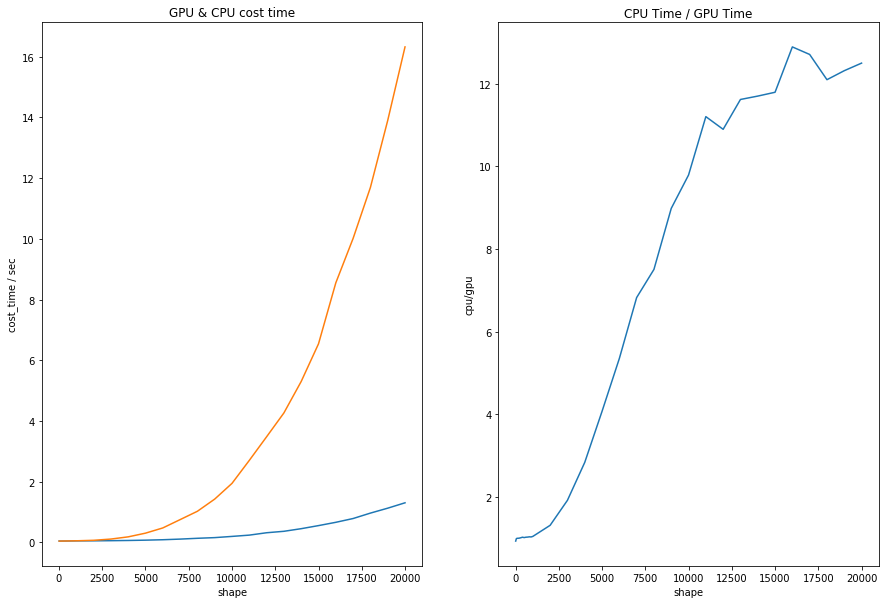

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt    
import numpy as np
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
ax[0].plot(shape_index, gpu_time)
ax[0].plot(shape_index, cpu_time)
ax[0].set_xlabel("shape")
ax[0].set_ylabel("cost_time / sec") 
ax[0].set_title("GPU & CPU cost time")

print(cpu_time)
print(gpu_time)
multiple = np.array(cpu_time) / np.array(gpu_time)
ax[1].plot(shape_index, multiple)
ax[1].set_xlabel("shape")
ax[1].set_ylabel("cpu/gpu") 
ax[1].set_title("CPU Time / GPU Time")

plt.show()

### GPU和CPU在网络上的对比

In [16]:
import tensorflow as tf
from datetime import datetime

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


startTime = datetime.now()
with tf.device('/gpu:0'):
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(1000, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1000, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1000, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.fit(x_train, y_train, epochs=5)
    model.evaluate(x_test, y_test)
gpu_cost_time = datetime.now() - startTime


startTime = datetime.now()
with tf.device('/cpu:0'):
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(1000, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1000, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1000, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=5)
    model.evaluate(x_test, y_test)
cpu_cost_time = datetime.now() - startTime

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 4s 69us/sample - loss: 0.2288 - accuracy: 0.9329
Epoch 2/5
60000/60000 [==============================] - 4s 66us/sample - loss: 0.1239 - accuracy: 0.9644
Epoch 3/5
60000/60000 [==============================] - 4s 66us/sample - loss: 0.0990 - accuracy: 0.9722
Epoch 4/5
60000/60000 [==============================] - 4s 68us/sample - loss: 0.0870 - accuracy: 0.9756
Epoch 5/5
10000/10000 [==============================] - 0s 45us/sample - loss: 0.1058 - accuracy: 0.9714
Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 13s 218us/sample - loss: 0.2264 - accuracy: 0.9319
Epoch 2/5
60000/60000 [==============================] - 13s 215us/sample - loss: 0.1269 - accuracy: 0.9639
Epoch 3/5
60000/60000 [==============================] - 13s 214us/sample - loss: 0.0991 - accuracy: 0.9722
Epoch 4/5
60000/60000 [==============================] - 13s 214us/sample - loss: 0.0850 - accuracy:

In [17]:
print('GPU Cost Time：%s, CPU Cost Time：%s' % (str(gpu_cost_time), str(cpu_cost_time)))

GPU Cost Time：0:00:21.694848, CPU Cost Time：0:01:06.441993
